In [602]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd
import pickle as rtl
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from operator import itemgetter

# Metoda elementów skończonych dla n elementów

1. generujemy odpowiednią ilość subelementów, sortujemy ich węzły, usuwamy duplikaty i przypisujemy do każdej funkcji lokalnej elementu jednoznacznie funkcję globalną

In [603]:
def generateElements(subdivisions):
    print("subdivisions "+str(subdivisions))
    elements=[(x,y) for x in range(subdivisions+1) for y in range(subdivisions+1)]
    elements+=[(x+(subdivisions+1),y) for x in range(subdivisions+1) for y in range(subdivisions+1)]
    elements+=[(x+(subdivisions+1),y+(subdivisions+1)) for x in range(subdivisions+1) for y in range(subdivisions+1)]
    
    functions=[]
    functions=[(x,y) for x in range(subdivisions+2) for y in range(subdivisions+2)]
    functions+=[(x+(subdivisions+1),y) for x in range(subdivisions+2) for y in range(subdivisions+2)]
    functions+=[(x+(subdivisions+1),y+(subdivisions+1)) for x in range(subdivisions+2) for y in range(subdivisions+2)]
    
    functions=list(set(functions))
    functions.sort(key=itemgetter(1,0))
    
    newElements=[]
    for element in elements:
        elementFunctions=[]
        for (xmove,ymove) in [(x,y) for y in range(2) for x in range(2)]:
            elementFunctions.append(functions.index((xmove+element[0],ymove+element[1])))
        newElements.append(((element[0]/(subdivisions+1),element[1]/(subdivisions+1)),elementFunctions))
    #print("functions")
    #print(functions)
    return (functions,newElements)
    

.2. Musimy obliczyć gradienty funkcji lokalnych

In [604]:
signsX = [1, 1,-1, -1]
signsY = [1, -1, 1, -1]
def getBilinearForm(location,dimension,pos):
    return (1/4)*((dimension[1]/dimension[0])*signsX[pos[0]]*signsX[pos[1]]+
                (dimension[0]/dimension[1])*signsY[pos[0]]*signsY[pos[1]])

.3. Musimy obliczyć brzeg Neumanna. W pdf jest prawdopodobnie błąd, więc przyjmiemy Pi/4

In [605]:
def g(r, phi):
    return r ** 2 * np.sin(phi + (np.pi / 2)) ** 2
    
def g_cart(x, y):
    r, phi = polarFromCarth(x, x)
    return g(r, phi)

def polarFromCarth(x, y):
    phi = np.arctan2(y, x)
    r = np.sqrt(x ** 2 + y ** 2)
    return r, phi

In [606]:
def getEdges(element):
    coords = []
    coords.append(element[0])
    coords.append((element[0][0]+1,element[0][1]))
    coords.append((element[0][0]+1,element[0][1]+1))
    coords.append((element[0][0],element[0][1]+1))
    return [(coords[i],coords[(i+1)%4]) for i in range(4)]
def getMidAndNeuman(coords,dimensions,element,elements):
    (c1,c2)=coords
    mid=((c1[0]+c2[0])/2,(c1[1]+c2[1])/2)
    return (mid,(mid[0]==0 or mid[0]==2 or mid[1]==0 or mid[1]==2))
def getDirichlet(functions,dimensions):
    funs=[]
    for (i,fun) in enumerate(functions):
        if((fun[1]==dimensions[0]/2 and fun[0]>=0 and fun[0]<=dimensions[0]/2) or ((fun[0]==dimensions[0]/2 and fun[1]>=dimensions[0]/2 and fun[1]<=dimensions[0]))):
              funs.append(i)
    return funs
def getElements(coords,elements,dimensions):
    return next((x for x in elements if ((coords[0]>=x[0][0]) and (coords[0]<=(2/(dimensions[0])+x[0][0])) and ((coords[1]>=x[0][1])) and (coords[1]<=(2/(dimensions[1])+x[0][1])))), None)

In [610]:

def createAndSolve(elements,functions,dimensions):
    size=len(functions)
    B = np.zeros((size,size))
    L = np.zeros((size,1))
    for element in elements: # E
        for (c1,c2) in getEdges(element):
          #  print("elementEdges")
           # print(getEdges(element))
            nemuan=getMidAndNeuman((c1,c2),dimensions,element,elements)
            if(nemuan[1]):
                b1,b2 = (element[0][0],element[0][1])
                b1*=2/dimensions[0]
                b2*=2/dimensions[1]
                x = (nemuan[0][0])*2/dimensions[1]
                y = (nemuan[0][1])*2/dimensions[1]
                fn = element[1]
                a=(2/dimensions[0])
                L[fn[0]] += g_cart(x-1,y-1)*(1-(x-b1)/a)*(1-(y-b2)/a)
                L[fn[1]] += g_cart(x-1,y-1)*(x-b1)*(1-(y-b2)/a)
                L[fn[2]] += g_cart(x-1,y-1)*(x-b1)*(y-b2)/a
                L[fn[3]] += g_cart(x-1,y-1)*(1-(x-b1)/a)*(y-b2)/a
                
    for element in elements: # E
        for i in (0,1,2,3): # phi_i
            i1 = element[1][i]  
           # print(ii)
            for j in (0,1,2,3): # phi_j
                j1 = element[1][j]    
             #   print((1/4) * ( sx[i]*sx[j] + sy[i]*sy[j] ))
             #   print( #dimensions
                
                B[i1, j1] += getBilinearForm(element[0],dimensions,(i,j))
              #  print((i,j))
             #   B[ii, jj] += getBilinearForm(element[0],dimensions,(i,j))
              #  print((ii, jj))
   # print(functions)
    for f in getDirichlet(functions,dimensions):
        
        B[f,:]=0
        B[f,f]=1
        L[f]=0
    return np.linalg.solve(B,L)

subdivisions 0


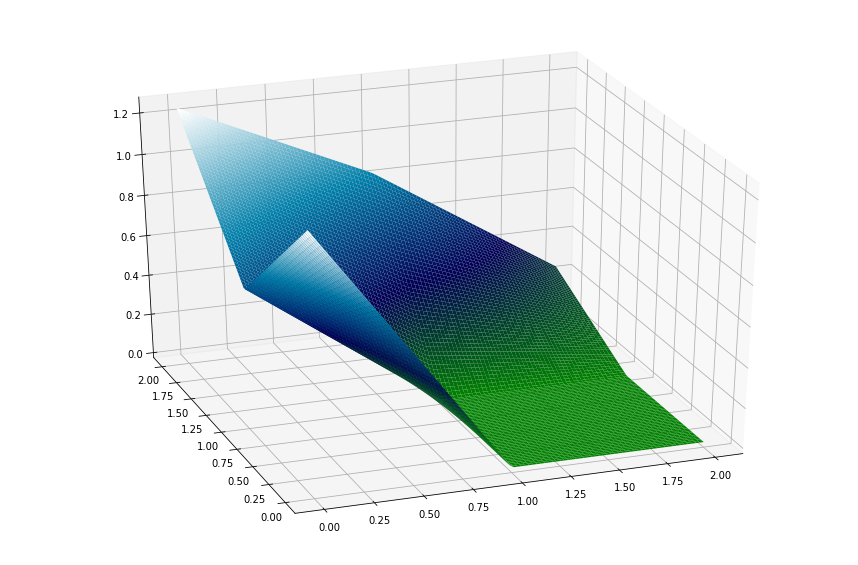

In [611]:
#@interact(subdivisions=(0,20))
def generatePlot(subdivisions):
    
    (functions,elements)=generateElements(subdivisions)
 #   print(pd.DataFrame(elements,columns=["xy","base functions"]))
    
  #  print("functions: "+str(functions))
    
    dimensions = ((subdivisions+1)*2,(subdivisions+1)*2)
   # print("dimensions: "+str(dimensions))
    
    a = createAndSolve(elements,functions,dimensions)
  #  print(a)
    
    probe(a,elements,functions,100,dimensions)
generatePlot(0)

In [609]:
def probe(a,elements,functions,n,dimensions):
    xprobe = np.linspace(0,2,n)
    yprobe = np.linspace(0,2,n)
    Z = np.zeros((len(xprobe),len(yprobe)))
    for (i,x) in enumerate(xprobe):
        for (j,y) in enumerate(yprobe):
           
            element=getElements((x,y),elements,dimensions)
          #  print(element)
            if(not element is None):
                b1,b2 = element[0]
                cx = (x - b1) 
                cy = (y - b2) 
                
                Z[i,j] += a[element[1][0]]*(1-cx)*(1-cy) 
                Z[i,j] += a[element[1][1]]*(cx)*(1-cy)   
                Z[i,j] += a[element[1][2]]*(1-cx)*(cy)   
                Z[i,j] += a[element[1][3]]*(cx)*(cy)                     
                
    fig = plt.figure(figsize=(15, 10))
    ax = fig.gca(projection='3d')

    X,Y = np.meshgrid(xprobe,yprobe)
    ax.plot_surface(X,Y,Z, rstride=1, cstride=1, cmap=plt.get_cmap('ocean'))
    ax.view_init(30, -110)

    plt.show()